<a href="https://colab.research.google.com/github/ShikhaVishwakarma/EagleView-DL-ML-Assignment-for-Data-Scientist/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.image import load_img, img_to_array

In [26]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
image_dir=Path('/content/gdrive/MyDrive/CarPerson')

In [29]:
filepaths=list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
1,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
2,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
3,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
4,/content/gdrive/MyDrive/CarPerson/Person/image...,Person
...,...,...
2234,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car
2235,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car
2236,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car
2237,/content/gdrive/MyDrive/CarPerson/Car/image_00...,Car


In [30]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [31]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [32]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 1254 validated image filenames belonging to 2 classes.
Found 313 validated image filenames belonging to 2 classes.
Found 672 validated image filenames belonging to 2 classes.


#Training


In [33]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
40/40 [==============================] - 42s 1s/step - loss: 0.6942 - accuracy: 0.4872 - val_loss: 0.6936 - val_accuracy: 0.4728 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 41s 1s/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6936 - val_accuracy: 0.4728 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 41s 1s/step - loss: 0.6945 - accuracy: 0.5072 - val_loss: 0.6922 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 41s 1s/step - loss: 0.6940 - accuracy: 0.4952 - val_loss: 0.6939 - val_accuracy: 0.4728 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 41s 1s/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6941 - val_accuracy: 0.4728 - lr: 0.0010
Epoch 6/100
40/40 [==============================] - 42s 1s/step - loss: 0.6932 - accuracy: 0.5088 - val_loss: 0.6934 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 7/100
40/40 [==============================] - 41s 1s/step - loss: 0.6

In [34]:
train_images.class_indices

{'Car': 0, 'Person': 1}

In [35]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.69370
Test Accuracy: 49.26%


In [37]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

#cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAR", "PERSON"])

#plt.figure(figsize=(6, 6))
#sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
#plt.xticks(ticks=[0.5, 1.5], labels=["CAR", "PERSON"])
#plt.yticks(ticks=[0.5, 1.5], labels=["CAR", "PRESON"])
#plt.xlabel("Predicted")
#plt.ylabel("Actual")
#plt.title("Confusion Matrix")
#plt.show()

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAR       0.49      1.00      0.66       332
      PERSON       0.00      0.00      0.00       340

    accuracy                           0.49       672
   macro avg       0.25      0.50      0.33       672
weighted avg       0.24      0.49      0.33       672



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image is of a car.


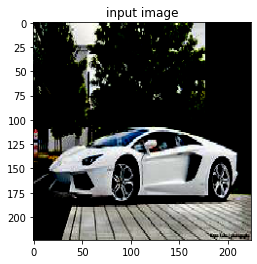

In [38]:
#Path to the image to see if the model predicts the correct class
path="/content/48a7eaf8914ce196bd77acacfb58b262.jpg"
img=load_img(path,target_size=(224,224))

i=img_to_array(img)
i=preprocess_input(i)

input_arr=np.array([i])
input_arr.shape

pred=np.argmax(model.predict(input_arr))

if pred==0:
  print('The image is of a car.')
else:
  print('The image is of a person.')

#To display an image
plt.imshow(input_arr[0])
plt.title('input image')
plt.show()